In [1]:
import os
import tqdm
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import numpy as np
from scipy.optimize import minimize
from skimage.restoration import estimate_sigma

import jax
import jax.numpy as jnp
from jax import random, grad, jit
from jax.config import config
config.update("jax_enable_x64", True)
key = random.PRNGKey(0)

from galaxy_vae.jax import VAE
from galaxy_vae.data import load_cosmos_galaxies, load_benchmark_galaxies

FS = 18  # Universal font size

## Create JAX beta-VAE from a Keras checkpoint

In [2]:
xdim = 64  # Image (xdim, xdim)
zdim = 64  # Latent space
checkpoint = os.path.join(os.path.dirname(os.getcwd()), 'data', 'epoch_320/Model')

vae = VAE(xdim, zdim)
vae.load_keras_model(checkpoint)

vmap_encode = jax.jit(jax.vmap(vae.encode))
jit_decode = jax.jit(vae.decode)

### Load training galaxies

In [3]:
# Pre-processed subset of COSMOS data
data = load_cosmos_galaxies()
print(f"Loaded {len(data)} galaxies")

# Normalise to [0, 1]
image_maxes = data.max(axis=(1, 2))
data /= image_maxes[..., None, None]
data = np.maximum(data, 0)

Loaded 19247 galaxies


### Compute the mean latent space vector

In [4]:
z_means, z_logvars = vmap_encode(data)
z_mean = z_means.mean(axis=0)
z_std = z_means.std(axis=0)
# z_std = jnp.exp(z_logvars / 2).mean(axis=0)

### Decode random draws from the latent space

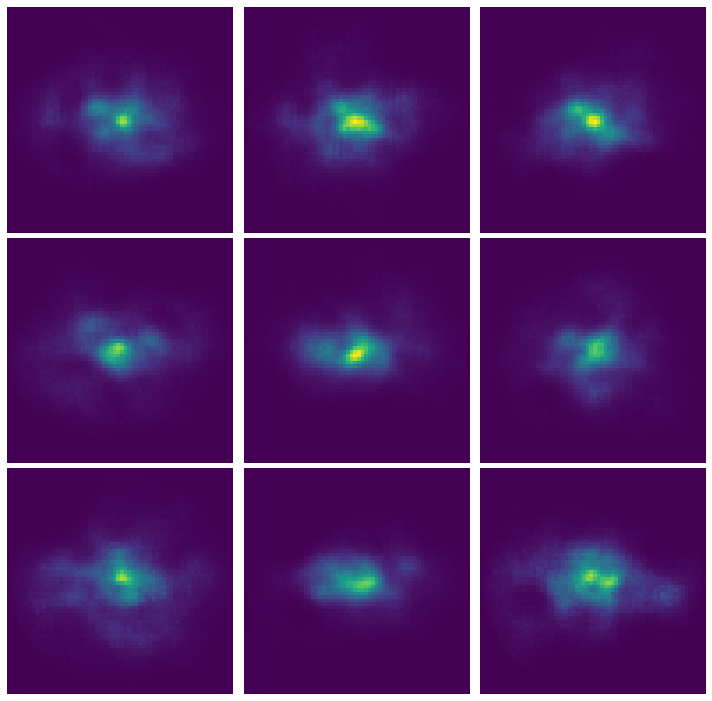

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax in np.ravel(axes):
    key, subkey = random.split(key)
    z = random.normal(subkey, (1, 1, zdim)) * z_std + z_mean
    x_rec = jit_decode(z)
    img = ax.imshow(x_rec, origin='lower', vmin=0, vmax=1)
    # ax.set_title(x_rec.shape)
    ax.set_axis_off()
    # fig.colorbar(img, ax=ax)
    fig.tight_layout()

## Benchmark galaxies

In [6]:
# Load benchmark galaxies
bm_galaxies = load_benchmark_galaxies()

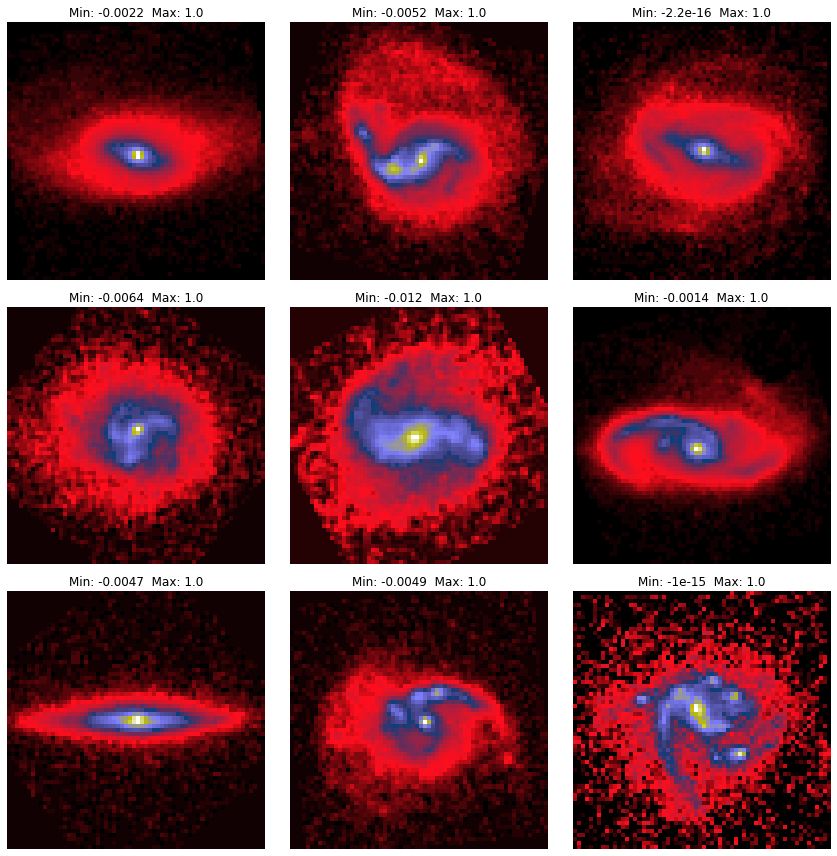

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for ax, image in zip(np.ravel(axes), bm_galaxies):
    ax.imshow(image, cmap='gist_stern')
    ax.set_axis_off()
    ax.set_title(f"Min: {image.min():.2}  Max: {image.max():.2}")
fig.tight_layout()

### MSE loss function

In [8]:
# @jax.jit
# def loss(z):
#     x_rec = vae.decode(z)
#     return jnp.sum((x_true - x_rec)**2) / 2

# @jax.jit
# def grad_loss(z):
#     return jnp.squeeze(jax.grad(loss)(z))

# @jax.jit
# def hess_loss(z):
#     return jnp.squeeze(jax.hessian(loss)(z))

def create_loss(x_true):
    def loss(z):
        x_rec = vae.decode(z)
        return chi_sq(x_rec, x_true)
    return jax.jit(loss)

def create_grad_loss(x_true):
    loss = create_loss(x_true)
    def grad_loss(z):
        return jnp.squeeze(jax.grad(loss)(z))
    return jax.jit(grad_loss)

def create_hess_loss(x_true):
    loss = create_loss(x_true)
    def hess_loss(z):
        return jnp.squeeze(jax.hessian(loss)(z))
    return jax.jit(hess_loss)

# Image chi-square
def chi_sq(x_obs, x_true):
    sigma = jnp.sqrt(jnp.abs(x_true) + x_true.max() * 1e-5)
    return jnp.sum(((x_true - x_obs) / sigma)**2)

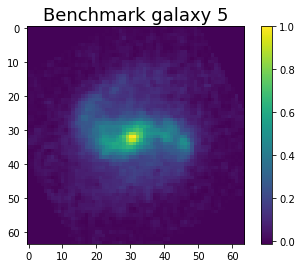

In [9]:
index = 4
x_true = jnp.array(np.squeeze(bm_galaxies[index]))
loss = create_loss(x_true)
grad_loss = create_grad_loss(x_true)
hess_loss = create_hess_loss(x_true)

fig, ax = plt.subplots(1, 1)
# img = ax.imshow(x_true, norm=colors.LogNorm(1e-3, 1), cmap='gist_stern')
img = ax.imshow(x_true)
fig.colorbar(img)
ax.set_title(f"Benchmark galaxy {index + 1}", fontsize=FS);

# Lensing
This part requires being on the `jaxify` branch of my lenstronomy fork at https://github.com/austinpeel/lenstronomy/tree/jaxify

In [10]:
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel

### Pixel grids

In [11]:
# Image plane
npix = 64
delta_pix = 0.08
half_size = (npix * delta_pix) / 2.
ra_at_xy_0, dec_at_xy_0 = -half_size + delta_pix / 2, -half_size + delta_pix / 2
transform_pix2angle = jnp.eye(2) * delta_pix
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0,
                'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
print("Image plane")
print("-----------")
print("image size : ({}, {})".format(npix, npix))
print("pixel size : {} arcsec".format(delta_pix))

# Source plane
supersampling_factor = 1
npix_s = npix * supersampling_factor
delta_pix_s = delta_pix / supersampling_factor
half_size_s = (npix_s * delta_pix_s) / 2.
ra_at_xy_0_s, dec_at_xy_0_s = -half_size_s + delta_pix_s / 2, -half_size_s + delta_pix_s / 2
transform_pix2angle_s = jnp.eye(2) * delta_pix_s
kwargs_pixel_s = {'nx': npix_s, 'ny': npix_s,
                 'ra_at_xy_0': ra_at_xy_0_s,
                 'dec_at_xy_0': dec_at_xy_0_s,
                 'transform_pix2angle': transform_pix2angle_s}

pixel_grid_s = PixelGrid(**kwargs_pixel_s)
xgrid_s, ygrid_s = pixel_grid_s.pixel_coordinates
x_coords, y_coords = xgrid_s[0, :], ygrid_s[:, 0]
print("\nSource plane")
print("------------")
print("image size : ({}, {})".format(npix_s, npix_s))
print("pixel size : {} arcsec".format(delta_pix_s))

Image plane
-----------
image size : (64, 64)
pixel size : 0.08 arcsec

Source plane
------------
image size : (64, 64)
pixel size : 0.08 arcsec


### Lens mass model

In [12]:
lens_mass_model = LensModel(['SIE', 'SHEAR'])

kwargs_sie = {'theta_E': 4. / 3, 'e1': 1. / 9, 'e2': 0., 'center_x': 0.0, 'center_y': 0.0}
kwargs_shear = {'gamma1': 0.0, 'gamma2': 0.03}
lens_mass_kwargs = [kwargs_sie, kwargs_shear]

### Lens light model

In [13]:
lens_light_model = LightModel([])
lens_light_kwargs = [{}]

### Source light model

In [14]:
source = x_true
source_light_model = LightModel(['PIXELATED'])
source_light_kwargs = [{'x_coords': x_coords, 'y_coords': y_coords, 'image': source}]

# source_light_model = LightModel(['INTERPOL'])
# source_light_kwargs = [{'image': x_true}]

# source_light_model = LightModel(['SERSIC'])
# source_light_kwargs = [{'amp': 10, 'R_sersic': 0.5, 'n_sersic': 3.0}]

### PSF (none for now)

In [15]:
psf_kwargs = {'psf_type': 'NONE'}
psf = PSF(**psf_kwargs)

### Lens the source

In [16]:
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}

image_model = ImageModel(data_class=pixel_grid, 
                         psf_class=psf, 
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         point_source_class=None,
                         kwargs_numerics=kwargs_numerics)

source_lensed = image_model.image(kwargs_lens=lens_mass_kwargs,
                                  kwargs_source=source_light_kwargs,
                                  kwargs_lens_light=lens_light_kwargs,
                                  kwargs_ps={})
source_lensed /= delta_pix**2

# # Add background noise
# exp_time = 500
# sigma_bkgd = 0.05
# prngkey, subkey1, subkey2 = random.split(prngkey, num=3)
# poisson = image_util.add_poisson(subkey1, source_lensed, exp_time=exp_time)
# bkgd = image_util.add_background(subkey2, source_lensed, sigma_bkd=sigma_bkgd)

# source_lensed_noisy = source_lensed + bkgd + poisson
# sigma_noise = sigma_bkgd

data = source_lensed

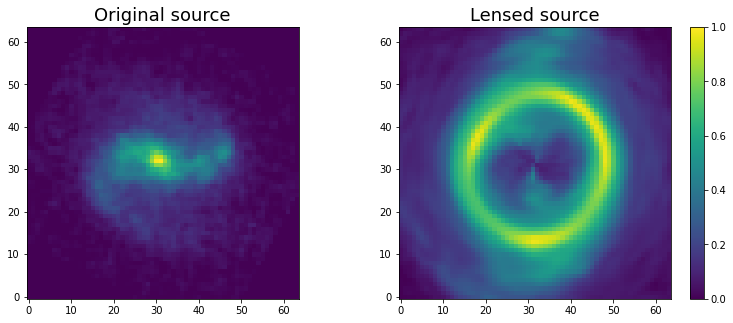

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.imshow(x_true, origin='lower', vmin=0, vmax=1)
img = ax2.imshow(data, origin='lower', vmin=0, vmax=1)
ax1.set_title("Original source", fontsize=FS)
ax2.set_title("Lensed source", fontsize=FS)
fig.colorbar(img)
fig.subplots_adjust(wspace=0)

### Optimise MSE loss

In [18]:
@jax.jit
def lens_loss(z):
    source_light_kwargs[0]['image'] = vae.decode(z)
    source_lensed = image_model.image(kwargs_lens=lens_mass_kwargs,
                                      kwargs_source=source_light_kwargs,
                                      kwargs_lens_light=lens_light_kwargs,
                                      kwargs_ps={})
    source_lensed /= delta_pix**2
    return jnp.sum((data - source_lensed)**2) / 2

@jax.jit
def grad_lens_loss(z):
    return jnp.squeeze(jax.grad(lens_loss)(z))

@jax.jit
def hess_lens_loss(z):
    return jnp.squeeze(jax.hessian(lens_loss)(z))

class Metrics(object):
    def __init__(self):
        self.loss = []
    
    def compute_metrics(self, z):
        self.loss.append(lens_loss(z))

In [19]:
# Initialise
key, subkey = random.split(key)
z0 = random.normal(subkey, (64,))
z0 = jnp.zeros((64,))

# Optimise
metrics = Metrics()
opt = minimize(lens_loss, z0, method='trust-krylov', jac=grad_lens_loss, hess=hess_lens_loss, 
               callback=metrics.compute_metrics)
# opt = minimize(lens_loss, z0, method='BFGS', jac=grad_lens_loss, callback=metrics.compute_metrics)
opt.fun

Buffer(0.67735517, dtype=float64)

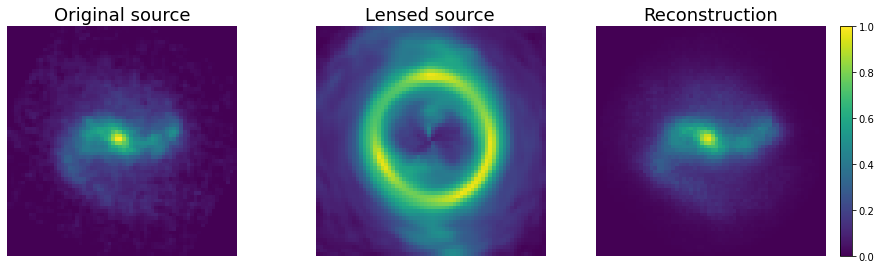

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(13, 4))
ax1.imshow(x_true, origin='lower', vmin=0, vmax=1)
ax1.set_title("Original source", fontsize=FS)
ax2.imshow(source_lensed, vmin=0, vmax=1)
ax2.set_title("Lensed source", fontsize=FS)
img = ax3.imshow(vae.decode(opt.x), origin='lower', vmin=0, vmax=1)
ax3.set_title("Reconstruction", fontsize=FS)
fig.colorbar(img)
fig.subplots_adjust(wspace=0)
fig.tight_layout()
for ax in (ax1, ax2, ax3):
    ax.set_axis_off()

Text(0.5, 0, 'Iteration')

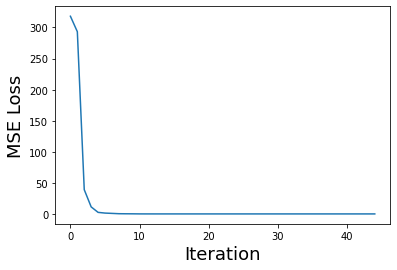

In [22]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(metrics.loss)), metrics.loss)
ax.set_ylabel("MSE Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)

In [23]:
opt

     fun: Buffer(0.67735517, dtype=float64)
    hess: array([[ 1.13848364, -0.28731263, -0.34113812, ...,  0.24749237,
        -0.03515976,  0.41450405],
       [-0.28731269,  0.81558704,  0.20781805, ..., -0.09068269,
        -0.00537784,  0.22664298],
       [-0.34113806,  0.207818  ,  0.69617295, ..., -0.12068154,
        -0.05042865, -0.06981217],
       ...,
       [ 0.24749254, -0.0906827 , -0.12068157, ...,  0.45814022,
         0.0782707 ,  0.10936381],
       [-0.03515961, -0.0053778 , -0.05042884, ...,  0.07827072,
         0.57496691, -0.02086281],
       [ 0.41450408,  0.22664295, -0.06981214, ...,  0.10936373,
        -0.02086288,  1.1015842 ]])
     jac: array([ 6.48084795e-04, -7.07342871e-04, -5.95912628e-04, -8.50794197e-04,
        3.93293158e-04, -1.55358255e-04, -1.24912255e-03,  3.20576160e-04,
        1.34801585e-03, -1.58398028e-03, -1.01829966e-04,  4.68967191e-05,
       -1.10275709e-04, -3.16042849e-03, -3.10773088e-04,  2.69948156e-04,
       -1.88349374e-03,